In [1]:
# Load packages
import sys
sys.path.append("..")
import os

import scipy.io as sio
import numpy as np
from scipy import stats

import random
import seaborn as sns

import matplotlib.pyplot as plt

# follow permutation method here: https://medium.com/analytics-vidhya/permutation-test-as-an-alternative-to-two-sample-t-test-using-r-9f5da921bc95


# Network community toolbox anaysis

Here we investigate the recruitment, integration, flexibility, and promiscuity of the modular allegiance matrices at the node level.

We do this by summing the values for each metric across the 98 nodes, and then comparing the mean of this value for 15 females vs 15 males. This is done by performing permutation tests with 10000 permutations.

In [2]:
os.getcwd()

'/Users/bengriffin/git_repos/Dyngraph/dyngraph-pain/Scripts/06-Sex_analyses/04-Dynamic_modular_analyses'

In [7]:
# Load metric data and join in new array
recruitment_all = sio.loadmat('../../../Data/04-Dynamic_modular_analyses/Network_community_toolbox/All_subjects/recruitment_all_subjects.mat')
integration_all = sio.loadmat('../../../Data/04-Dynamic_modular_analyses/Network_community_toolbox/All_subjects/integration_all_subjects.mat')
flexibility_all = sio.loadmat('../../../Data/04-Dynamic_modular_analyses/Network_community_toolbox/All_subjects/flexibility_all_subjects.mat')
promiscuity_all = sio.loadmat('../../../Data/04-Dynamic_modular_analyses/Network_community_toolbox/All_subjects/promiscuity_all_subjects.mat')

recr = recruitment_all['Recruitment']
integ = integration_all['Integration']
flex = flexibility_all['flex_mean']
prom = promiscuity_all['prom_mean']

n_roi = 98
n_freq = 6
n_metric = 4
metric_array_node = np.stack((recr, integ, flex, prom), axis = 3)
metric_array_sum = metric_array_node.sum(axis=0) # We sum up the data so that we can perform the analysis at the highest level


In [8]:
metric_female_mean_sum = metric_array_sum[:,0:15,:].mean(axis=1)
metric_male_mean_sum = metric_array_sum[:,15:30,:].mean(axis=1)

metric_female_mean_node = metric_array_node[:,:,0:15,:].mean(axis=2)
metric_male_mean_node = metric_array_node[:,:,15:30,:].mean(axis=2)


mean_dif_metric_sum = np.transpose(abs(metric_female_mean_sum - metric_male_mean_sum))
mean_dif_metric_node = abs(metric_female_mean_node - metric_male_mean_node)

print(mean_dif_metric_sum)

[[0.80497379 1.65902424 0.29607507 1.53405644 2.25119672 1.36166372]
 [0.79741024 1.61560783 0.07853802 1.25566847 2.17644106 0.55094695]
 [0.00316049 0.07797531 0.16483951 0.08735802 0.0645679  0.21323457]
 [0.85813651 0.99448889 0.95166667 1.12965556 0.00534444 1.71294444]]


### Run permutation test

In [ ]:
# This currently doesn't work for node level, but we don't see any significant results at the highest level so not worth investigating

n_roi = 98
n_freq = 6
n_metric = 4
n_perm = 10000

null_dist_metric_sum = np.zeros((n_perm,n_metric,n_freq))
#null_dist_metric_node = np.zeros((n_perm,n_metric,n_roi,n_freq))

p_value_metric_sum = np.zeros((n_metric,n_freq))
#p_value_metric_node = np.zeros((n_metric,n_roi,n_freq))



for metric in range(n_metric):
    for freq in range(n_freq):
        data_sum = metric_array_sum[freq,:,metric] # Get the data for all 30 subjects
        # Get the data for all 30 subjects and put subject data in first column so that we can random.shuffle (which works along first axis)
        #data_node = np.transpose(metric_array_node[:,freq,:,metric],(1,0))
        
        data_sum_copy = data_sum.copy() # create a copy 
        #data_node_copy = data_node.copy() # create a copy 
        random.seed(123) # set seed for reproducibility

        # Perform randomization 10000 times
        for perm in range(n_perm):
            random.shuffle(data_sum_copy)
            shuffled_female_sum = data_sum_copy[0:15]
            shuffled_male_sum = data_sum_copy[15:30]
            
            #random.shuffle(data_node_copy) # Why does this affect the sum permutation test? because the random.seed
            # changes by 2 each time it assesses the first one
            #shuffled_female_node = data_node_copy[0:15,:]
            #shuffled_male_node = data_node_copy[15:30,:]
            
            
            null_dist_metric_sum[perm,metric,freq] = abs(shuffled_female_sum.mean(axis=0) - shuffled_male_sum.mean(axis=0))
            #null_dist_metric_node[perm,metric,:,freq] = abs(shuffled_female_node.mean(axis=0) - shuffled_male_node.mean(axis=0))
    
        # Calc number of permutations that are greater than the mean calculated earlier and divide this by number 
        # of permutations to get the p-values
        p_value_metric_sum[metric, freq] = (sum(i > mean_dif_metric_sum[metric,freq] for i in null_dist_metric_sum[:,metric,freq]))/n_perm
        #p_value_metric_node[metric, :,freq] = (sum(i > mean_dif_metric_node[:,metric,freq] for i in null_dist_metric_node[:,metric,:,freq]))/n_perm
    
print(p_value_metric_sum)
#print(p_value_metric_node[1,:,1]*98)

# test for significance
p_value_metric_sum > 0.05

# We get that all results are true - this means there is no significant difference in males vs females in terms of
# total recruitment/integration/flexibility/promiscuity

### System level promiscuity and flexibility (male vs female)

In [9]:
n_sys = 7
n_sub = 30
n_freq = 6
n_roi = 98

system_idx = np.loadtxt('../../../Data/04-Dynamic_modular_analyses/Functional_system_data/Original/AAL_module_assigned_numbers.txt')

system_flex = np.zeros((n_sys, n_freq, n_sub))
system_prom = np.zeros((n_sys, n_freq, n_sub))
system_recr = np.zeros((n_sys, n_freq, n_sub))

n_sys_node = np.zeros((n_sys))


for sys in range(n_sys):
    sys_idx = sys + 1 # We add 1 because system index starts at 1
    indices = [i for i, x in enumerate(system_idx) if x == sys_idx]
    n_sys_node[sys] = len(indices)
    print(indices)
    #system_flex[sys,:,:] = sum(flex[indices,:,:])
    #system_prom[sys,:,:] = sum(prom[indices,:,:])
    
    system_flex[sys,:,:] = (sum(flex[indices,:,:]))/n_sys_node[sys]
    system_prom[sys,:,:] = sum(prom[indices,:,:])/n_sys_node[sys]
    system_recr[sys,:,:] = sum(recr[indices,:,:])/n_sys_node[sys]

print(n_sys_node)
    
system_flex_f = system_flex[:,:,0:15]
system_flex_m = system_flex[:,:,15:30]

system_prom_f = system_prom[:,:,0:15]
system_prom_m = system_prom[:,:,15:30]

print(system_flex_f.shape)

system_flex_f_mean = system_flex_f.mean(axis=2)
system_flex_m_mean = system_flex_m.mean(axis=2)

system_prom_f_mean = system_prom_f.mean(axis=2)
system_prom_m_mean = system_prom_m.mean(axis=2)

print(system_flex_f_mean.shape)

mean_dif_system_flex = abs(system_flex_f_mean - system_flex_m_mean)
mean_dif_system_prom = abs(system_prom_f_mean - system_prom_m_mean)

# Should I normalise each value for the number of nodes that are in each system?


[16, 17, 72, 73, 74, 75, 76, 77, 78, 79]
[8, 9, 14, 15, 24, 25, 26, 27, 32, 33, 58, 59, 60, 61, 80, 81, 90, 91, 92, 93, 94, 95, 96, 97]
[2, 3, 4, 5, 6, 7, 22, 23, 54, 55, 82, 83]
[10, 11, 12, 13, 28, 29, 52, 53, 56, 57, 84, 85]
[0, 1, 18, 19, 50, 51, 62, 63, 86, 87, 88, 89]
[20, 21, 30, 31, 34, 35, 64, 65, 66, 67, 68, 69, 70, 71]
[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[10. 24. 12. 12. 12. 14. 14.]
(7, 6, 15)
(7, 6)


In [10]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
print(mean_dif_system_flex)
print(mean_dif_system_prom)

[[0.007494 0.001546 0.001709 0.000042 0.002398 0.004336]
 [0.005526 0.003404 0.002245 0.001404 0.000452 0.000607]
 [0.007195 0.012101 0.000728 0.004311 0.003757 0.002578]
 [0.001630 0.006152 0.003356 0.000909 0.001138 0.001846]
 [0.006564 0.005486 0.002648 0.000759 0.003128 0.006556]
 [0.001233 0.007092 0.000677 0.003623 0.000889 0.004085]
 [0.004818 0.004383 0.007400 0.002025 0.002349 0.004099]]
[[0.036650 0.002915 0.010647 0.009208 0.013358 0.035456]
 [0.014779 0.009337 0.012880 0.012806 0.004200 0.002014]
 [0.040875 0.055477 0.000877 0.027596 0.033020 0.017028]
 [0.006864 0.009691 0.013494 0.001697 0.005387 0.020444]
 [0.026662 0.027521 0.011871 0.005056 0.013439 0.047889]
 [0.009852 0.032773 0.002311 0.020330 0.000822 0.027952]
 [0.013173 0.006485 0.033837 0.002388 0.010265 0.028552]]


### Run permutation test

In [11]:
n_perm = 10000
n_sys = 7
n_freq = 6

null_dist_flex_sys = np.zeros((n_perm,n_sys,n_freq))
null_dist_prom_sys = np.zeros((n_perm,n_sys,n_freq))

p_value_flex_sum = np.zeros((n_sys,n_freq))
p_value_prom_sum = np.zeros((n_sys,n_freq))

system_flex_rearranged = np.transpose(system_flex,(2,1,0)) # Put subject data in first column (since random.shuffle works on first column)
system_prom_rearranged = np.transpose(system_prom,(2,1,0)) # Put subject data in first column (since random.shuffle works on first column)


for sys in range(n_sys):
    print(sys)
    for freq in range(n_freq):
        
        data_sum_flex = system_flex_rearranged[:, freq, sys] # Get the data for all 30 subjects and put subject data
        data_sum_prom = system_prom_rearranged[:, freq, sys] # Get the data for all 30 subjects and put subject data
        
        data_sum_flex_copy = data_sum_flex.copy() # create a copy 
        data_sum_prom_copy = data_sum_prom.copy() # create a copy 
        random.seed(123) # set seed for reproducibility

        # Perform randomisation 10000 times
        for perm in range(n_perm):
            random.shuffle(data_sum_flex_copy)
            random.shuffle(data_sum_prom_copy)
            
            shuffled_female_sum_flex = data_sum_flex_copy[0:15]
            shuffled_male_sum_flex = data_sum_flex_copy[15:30]

            shuffled_female_sum_prom = data_sum_prom_copy[0:15]
            shuffled_male_sum_prom = data_sum_prom_copy[15:30]
            
            
            null_dist_flex_sys[perm,sys,freq] = abs(shuffled_female_sum_flex.mean(axis=0) - shuffled_male_sum_flex.mean(axis=0))
            null_dist_prom_sys[perm,sys,freq] = abs(shuffled_female_sum_prom.mean(axis=0) - shuffled_male_sum_prom.mean(axis=0))

    
        # Calc number of permutations that are greater than the mean calculated earlier and divide this by number 
        # of permutations to get the p-values
        p_value_flex_sum[sys,freq] = (sum(i > mean_dif_system_flex[sys,freq] for i in null_dist_flex_sys[:,sys,freq]))/n_perm
        p_value_prom_sum[sys,freq] = (sum(i > mean_dif_system_prom[sys,freq] for i in null_dist_prom_sys[:,sys,freq]))/n_perm
    
print(p_value_flex_sum)
print(p_value_prom_sum)

# test for significance
print(p_value_flex_sum > 0.05)
print(p_value_prom_sum > 0.05)

# We get that all results are true - this means there is no significant difference in males vs females in terms of
# system flexibility/promiscuity??

0
1
2
3
4
5
6
[[0.172700 0.620400 0.496000 0.984300 0.215200 0.091500]
 [0.207300 0.318900 0.521500 0.462300 0.802400 0.740200]
 [0.315800 0.086600 0.888800 0.168300 0.051400 0.290800]
 [0.794300 0.152700 0.408500 0.766000 0.545400 0.495600]
 [0.236100 0.353900 0.547000 0.811300 0.138000 0.049100]
 [0.800600 0.091800 0.849000 0.235300 0.711200 0.164900]
 [0.513200 0.487800 0.137200 0.580200 0.507800 0.317700]]
[[0.140000 0.830200 0.324000 0.389900 0.405700 0.099700]
 [0.481800 0.513000 0.344700 0.117300 0.768400 0.895200]
 [0.225400 0.070500 0.975600 0.058000 0.034400 0.426300]
 [0.776000 0.585400 0.409600 0.912200 0.721300 0.380700]
 [0.300000 0.232700 0.540500 0.674700 0.424200 0.062200]
 [0.651000 0.041400 0.852500 0.151800 0.965600 0.267300]
 [0.729800 0.817200 0.165600 0.900500 0.713400 0.354400]]
[[ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  Tru

### System level promiscuity and flexibility (mean across 30 subjects)

(7, 6)


Text(0.5, 0, 'Frequency band')

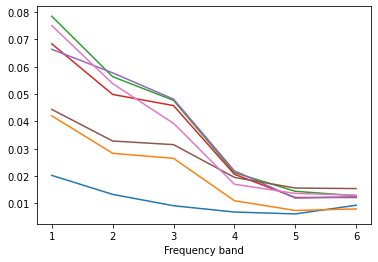

In [13]:
system_flex_mean = system_flex.mean(axis=2)
system_prom_mean = system_prom.mean(axis=2)
print(system_flex_mean.shape)
system_flex_mean[0,:]

plt.plot([1, 2, 3, 4, 5, 6], system_flex_mean[0,:])
plt.plot([1, 2, 3, 4, 5, 6], system_flex_mean[1,:])
plt.plot([1, 2, 3, 4, 5, 6], system_flex_mean[2,:])
plt.plot([1, 2, 3, 4, 5, 6], system_flex_mean[3,:])
plt.plot([1, 2, 3, 4, 5, 6], system_flex_mean[4,:])
plt.plot([1, 2, 3, 4, 5, 6], system_flex_mean[5,:])
plt.plot([1, 2, 3, 4, 5, 6], system_flex_mean[6,:])
plt.xlabel('Frequency band')

Text(0.5, 0, 'Frequency band')

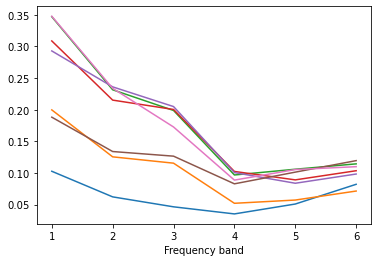

In [37]:
plt.plot([1, 2, 3, 4, 5, 6], system_prom_mean[0,:])
plt.plot([1, 2, 3, 4, 5, 6], system_prom_mean[1,:])
plt.plot([1, 2, 3, 4, 5, 6], system_prom_mean[2,:])
plt.plot([1, 2, 3, 4, 5, 6], system_prom_mean[3,:])
plt.plot([1, 2, 3, 4, 5, 6], system_prom_mean[4,:])
plt.plot([1, 2, 3, 4, 5, 6], system_prom_mean[5,:])
plt.plot([1, 2, 3, 4, 5, 6], system_prom_mean[6,:])
plt.xlabel('Frequency band')

In [19]:
# In order to recreate these graphs in MATLAB, we save the system level flexibility and promiscuity
import scipy.io
scipy.io.savemat('../../../Data/04-Dynamic_modular_analyses/Network_community_toolbox/All_subjects/system_flex.mat', {"system_flex":system_flex})
scipy.io.savemat('../../../Data/04-Dynamic_modular_analyses/Network_community_toolbox/All_subjects/system_prom.mat', {"system_prom":system_prom})

# Modular allegiance analysis

In this section we investigate the modular allegiance of the brain networks, this time at the system level. We use permutation tests with 10,000 permutations to see if there is a significant difference between males and females for each of the systems:
Auditory, default mode, frontoparietal, sensorimotor, visual, salience, subcortical.

Note that since frequency bands are independent, we don't have to worry about issues of multiple comparisons regarding them.

In [20]:
n_sys = 7
# Load metric data and join in new array - let's do normalized to begin with but then maybe also non-normalized
recr_integ_all = np.load('../../../Data/04-Dynamic_modular_analyses/Recruitment_Integration/whole-brain_normalised_mean_allegiance.npy')
print(recr_integ_all.shape)

recr_integ_female_mean = recr_integ_all[:,1:15,:,:].mean(axis=1)
recr_integ_male_mean = recr_integ_all[:,15:30,:,:].mean(axis=1)

mean_recr_integ = abs(recr_integ_male_mean - recr_integ_female_mean)
print(mean_recr_integ.shape)

(6, 30, 7, 7)
(6, 7, 7)


In [21]:
n_perm = 10000
n_freq = 6
n_sys= 7

null_dist_recr_integ = np.zeros((n_perm,n_freq,n_sys,n_sys))
p_value_recr_integ = np.zeros((n_freq,n_sys,n_sys ))




for freq in range(n_freq):
    print(freq)
    for sys1 in range(n_sys):
        for sys2 in range(n_sys):
            data = recr_integ_all[freq,:,sys1,sys2] # Get the data for all 30 subjects

            data_copy = data.copy() # create a copy 
            random.seed(123) # set seed for reproducibility

            # Perform randomization 10000 times
            for perm in range(n_perm):
                random.shuffle(data_copy)
                shuffled_female = data_copy[0:15]
                shuffled_male = data_copy[15:30]
                null_dist_recr_integ[perm,freq,sys1,sys2] = abs(shuffled_female.mean(axis=0) - shuffled_male.mean(axis=0))
                
            # Calc number of permutations that are greater than the mean calculated earlier and divide this by number 
            # of permutations to get the p-values
            p_value_recr_integ[freq,sys1,sys2] = (sum(i > mean_recr_integ[freq,sys1,sys2] for i in null_dist_recr_integ[:,freq,sys1,sys2]))/n_perm
            
    
    
print(p_value_recr_integ)



0
1
2
3
4
5
[[[0.360500 0.962200 0.677400 0.876200 0.260900 0.495000 0.278900]
  [0.962200 0.171000 0.084800 0.713100 0.313100 0.328700 0.474400]
  [0.677400 0.084800 0.464700 0.300100 0.087200 0.392100 0.445800]
  [0.876200 0.713100 0.300100 0.831900 0.329800 0.885100 0.013100]
  [0.260900 0.313100 0.087200 0.329800 0.100800 0.111800 0.064100]
  [0.495000 0.328700 0.392100 0.885100 0.111800 0.590000 0.054700]
  [0.278900 0.474400 0.445800 0.013100 0.064100 0.054700 0.529400]]

 [[0.915700 0.314900 0.970100 0.263100 0.159900 0.809700 0.179700]
  [0.314900 0.577400 0.176500 0.448100 0.995100 0.898100 0.785800]
  [0.970100 0.176500 0.330600 0.927900 0.223600 0.598800 0.871700]
  [0.263100 0.448100 0.927900 0.411000 0.540400 0.064200 0.001000]
  [0.159900 0.995100 0.223600 0.540400 0.424000 0.283000 0.007600]
  [0.809700 0.898100 0.598800 0.064200 0.283000 0.687100 0.799100]
  [0.179700 0.785800 0.871700 0.001000 0.007600 0.799100 0.267900]]

 [[0.092300 0.437800 0.960400 0.276500 0.69990

In [22]:
print(p_value_recr_integ)
print(p_value_recr_integ>0.05)

[[[0.360500 0.962200 0.677400 0.876200 0.260900 0.495000 0.278900]
  [0.962200 0.171000 0.084800 0.713100 0.313100 0.328700 0.474400]
  [0.677400 0.084800 0.464700 0.300100 0.087200 0.392100 0.445800]
  [0.876200 0.713100 0.300100 0.831900 0.329800 0.885100 0.013100]
  [0.260900 0.313100 0.087200 0.329800 0.100800 0.111800 0.064100]
  [0.495000 0.328700 0.392100 0.885100 0.111800 0.590000 0.054700]
  [0.278900 0.474400 0.445800 0.013100 0.064100 0.054700 0.529400]]

 [[0.915700 0.314900 0.970100 0.263100 0.159900 0.809700 0.179700]
  [0.314900 0.577400 0.176500 0.448100 0.995100 0.898100 0.785800]
  [0.970100 0.176500 0.330600 0.927900 0.223600 0.598800 0.871700]
  [0.263100 0.448100 0.927900 0.411000 0.540400 0.064200 0.001000]
  [0.159900 0.995100 0.223600 0.540400 0.424000 0.283000 0.007600]
  [0.809700 0.898100 0.598800 0.064200 0.283000 0.687100 0.799100]
  [0.179700 0.785800 0.871700 0.001000 0.007600 0.799100 0.267900]]

 [[0.092300 0.437800 0.960400 0.276500 0.699900 0.176900 0

In [23]:
# test for significance (account for multiple comparisons problems) - uses bonferri correction
critical_p_value = 0.05/28#(n_sys*n_sys)
print(p_value_recr_integ)
print(p_value_recr_integ > critical_p_value)

[[[0.360500 0.962200 0.677400 0.876200 0.260900 0.495000 0.278900]
  [0.962200 0.171000 0.084800 0.713100 0.313100 0.328700 0.474400]
  [0.677400 0.084800 0.464700 0.300100 0.087200 0.392100 0.445800]
  [0.876200 0.713100 0.300100 0.831900 0.329800 0.885100 0.013100]
  [0.260900 0.313100 0.087200 0.329800 0.100800 0.111800 0.064100]
  [0.495000 0.328700 0.392100 0.885100 0.111800 0.590000 0.054700]
  [0.278900 0.474400 0.445800 0.013100 0.064100 0.054700 0.529400]]

 [[0.915700 0.314900 0.970100 0.263100 0.159900 0.809700 0.179700]
  [0.314900 0.577400 0.176500 0.448100 0.995100 0.898100 0.785800]
  [0.970100 0.176500 0.330600 0.927900 0.223600 0.598800 0.871700]
  [0.263100 0.448100 0.927900 0.411000 0.540400 0.064200 0.001000]
  [0.159900 0.995100 0.223600 0.540400 0.424000 0.283000 0.007600]
  [0.809700 0.898100 0.598800 0.064200 0.283000 0.687100 0.799100]
  [0.179700 0.785800 0.871700 0.001000 0.007600 0.799100 0.267900]]

 [[0.092300 0.437800 0.960400 0.276500 0.699900 0.176900 0

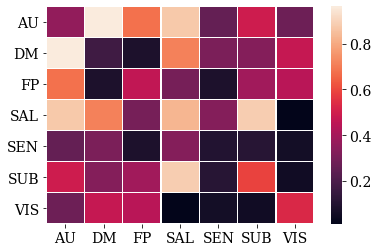

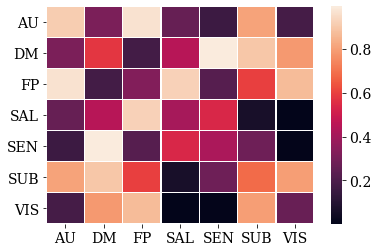

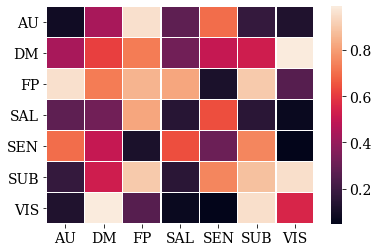

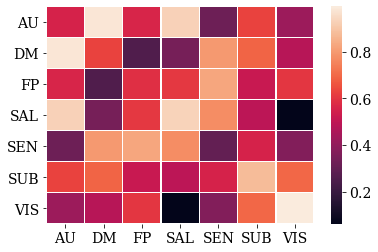

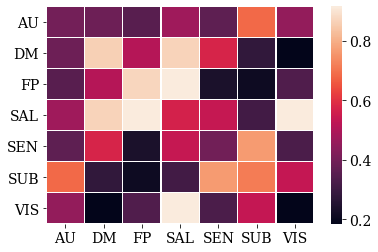

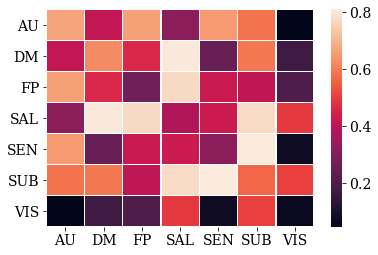

In [25]:
import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
n_freq = 6
freq_band_list = ['Delta','Theta','Alpha','Beta','Low gamma','High gamma']
x_axis_labels = ['AU','DM','FP','SAL','SEN','SUB','VIS']
y_axis_labels = ['AU','DM','FP','SAL','SEN','SUB','VIS']

for freq in range(n_freq):
    uniform_data = p_value_recr_integ[freq,:,:]
    ax = sns.heatmap(uniform_data, linewidth=0.5,xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    #plt.title(freq_band_list[freq])
    plt.show()
    